## SINGLE LAYER

In [23]:
SAVE_FOLDER = "DGIDB_BIPOLAR"
SAVE_DIR = f"saliency_output/{SAVE_FOLDER}"
SAVE_DIR_VECTORS = f"saliency_output/{SAVE_FOLDER}/vector/"
FOLDER = "DGIDB_BIPOLAR/"
HYPERGRAPH_DIRECTORY = "../Gen_Hypergraph/output/" + FOLDER

In [2]:
import numpy as np
import os
import pandas as pd
from scipy.sparse import load_npz, csr_matrix
import json
# Load matrices

binary_matrix = load_npz(HYPERGRAPH_DIRECTORY + "hypergraph_incidence_matrix_binary.npz").tocsr()
weighted_matrix = load_npz(HYPERGRAPH_DIRECTORY + "hypergraph_incidence_matrix_weighted.npz").tocsr()


num_genes = binary_matrix.shape[0]
num_drugs = binary_matrix.shape[1]

# Initialize probability vectors
v0 = np.ones(num_genes) / num_genes
teleport = np.ones(num_genes) / num_genes

def get_hyper_randomwalk(binary_matrix, weighted_matrix, restart_prob=0.8, num_iterations=10):
    vi = v0.copy()
    distance_list = []

    for k in range(num_iterations):
        vj = vi.copy()
        vi_new = np.zeros(num_genes)

        for gene in range(num_genes):
            connected_drugs = binary_matrix[gene, :].nonzero()[1]
            if len(connected_drugs) == 0:
                continue

            prob_sum = 0
            for drug in connected_drugs:
                connected_genes = weighted_matrix[:, drug].toarray().flatten()
                neighbor_genes = np.where(connected_genes > 0)[0]

                if len(neighbor_genes) == 0:
                    continue

                weights = connected_genes[neighbor_genes]
                weight_sum = np.sum(weights)
                if weight_sum > 0:
                    weights /= weight_sum

                prob_sum += np.sum(weights * vj[neighbor_genes])

            vi_new[gene] = prob_sum

        vi_new /= np.sum(vi_new) if np.sum(vi_new) > 0 else 1
        vi = restart_prob * vi_new + (1 - restart_prob) * teleport
        distance = np.sum(np.abs(vj - vi))
        distance_list.append(distance)

    importance_scores = np.argsort(vi)[::-1]
    importance_values = vi[importance_scores]
    return list(zip(importance_scores, importance_values)), vi  # Return both ranked and raw vector

In [3]:
# Save directory for saliency scores
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(SAVE_DIR_VECTORS, exist_ok=True)

# Get baseline (full graph) run
baseline_ranked, baseline_vector = get_hyper_randomwalk(binary_matrix, weighted_matrix)

# Save baseline
df_baseline = pd.DataFrame(baseline_ranked, columns=["GeneIndex", "Score"])
df_baseline.to_csv(os.path.join(SAVE_DIR, "baseline.csv"), index=False)

# Perturb each drug (remove one hyperedge at a time)
from tqdm import tqdm

skipped = []

for drug_idx in tqdm(range(num_drugs), desc="Running saliency analysis"):
    # Skip drug if it has no connections
    if binary_matrix[:, drug_idx].nnz == 0:
        skipped.append(drug_idx)
        continue

    # Make copies to modify
    binary_copy = binary_matrix.copy().tolil()
    weighted_copy = weighted_matrix.copy().tolil()

    # Zero out the drug column (remove the hyperedge)
    binary_copy[:, drug_idx] = 0
    weighted_copy[:, drug_idx] = 0

    # Convert back to csr for efficiency
    binary_csr = binary_copy.tocsr()
    weighted_csr = weighted_copy.tocsr()

    # Run random walk on the perturbed graph
    ranked_scores, vi = get_hyper_randomwalk(binary_csr, weighted_csr)
    print(f"Saved to saliency_drug_{drug_idx}.csv")

    # Save to CSV
    df = pd.DataFrame(ranked_scores, columns=["GeneIndex", "Score"])
    df.to_csv(os.path.join(SAVE_DIR, f"saliency_drug_{drug_idx}.csv"), index=False)
    np.save(SAVE_DIR_VECTORS + f'DGIDB_vector_{drug_idx}.npy', vi)


# Optionally print or save skipped drugs
print(f"Skipped {len(skipped)} drug(s) with no connections: {skipped}")

print("✅ Done generating saliency scores.")


Running saliency analysis:   1%|          | 191/17908 [00:04<06:30, 45.41it/s]

Saved to saliency_drug_190.csv


Running saliency analysis:   2%|▏         | 372/17908 [00:08<06:23, 45.69it/s]

Saved to saliency_drug_371.csv


Running saliency analysis:   2%|▏         | 396/17908 [00:12<10:46, 27.10it/s]

Saved to saliency_drug_395.csv


Running saliency analysis:   3%|▎         | 560/17908 [00:16<09:09, 31.55it/s]

Saved to saliency_drug_559.csv


Running saliency analysis:   4%|▍         | 718/17908 [00:21<09:06, 31.48it/s]

Saved to saliency_drug_717.csv


Running saliency analysis:   5%|▍         | 844/17908 [00:26<09:32, 29.81it/s]

Saved to saliency_drug_843.csv


Running saliency analysis:   6%|▌         | 1031/17908 [00:30<07:59, 35.23it/s]

Saved to saliency_drug_1030.csv


Running saliency analysis:   8%|▊         | 1439/17908 [00:34<05:01, 54.64it/s]

Saved to saliency_drug_1438.csv


Running saliency analysis:   8%|▊         | 1459/17908 [00:38<06:56, 39.49it/s]

Saved to saliency_drug_1458.csv


Running saliency analysis:  10%|▉         | 1734/17908 [00:42<05:31, 48.73it/s]

Saved to saliency_drug_1733.csv


Running saliency analysis:  12%|█▏        | 2166/17908 [00:46<03:56, 66.52it/s]

Saved to saliency_drug_2165.csv


Running saliency analysis:  26%|██▌       | 4639/17908 [00:50<00:46, 287.03it/s]

Saved to saliency_drug_2915.csv


Running saliency analysis: 100%|██████████| 17908/17908 [00:51<00:00, 350.46it/s] 

Skipped 17896 drug(s) with no connections: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 2

In [24]:
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import json

with open(HYPERGRAPH_DIRECTORY + "gene_to_index.json", "r") as file:
    gene_to_index = json.load(file)
with open(HYPERGRAPH_DIRECTORY + "drug_to_index.json", "r") as file:
    drug_to_index = json.load(file)
# Path to folder containing saliency CSVs
SAL_DIR = "saliency_output/DGIDB_BIPOLAR/"

# Load baseline
baseline_df = pd.read_csv(os.path.join(SAL_DIR, "baseline.csv"))
baseline_scores = baseline_df.set_index("GeneIndex")["Score"]

# Initialize storage
saliency_matrix = []
drug_indices = []

# Regex pattern to extract drug index
pattern = re.compile(r"saliency_drug_(\d+)\.csv")

# List all saliency CSV files except baseline
csv_files = [f for f in os.listdir(SAL_DIR) if pattern.match(f)]

for fname in tqdm(sorted(csv_files, key=lambda f: int(pattern.match(f).group(1)))):
    drug_idx = int(pattern.match(fname).group(1))
    fpath = os.path.join(SAL_DIR, fname)

    perturbed_df = pd.read_csv(fpath)
    perturbed_scores = perturbed_df.set_index("GeneIndex")["Score"]

    # Align with baseline and compute saliency
    aligned = baseline_scores.subtract(perturbed_scores, fill_value=0)
    saliency_matrix.append(aligned.values)
    drug_indices.append(drug_idx)

# Create DataFrame: rows = drugs, cols = genes
saliency_df = pd.DataFrame(saliency_matrix, index=drug_indices, columns=baseline_scores.index)
# Invert the drug_to_index dictionary: index -> drug name
index_to_drug = {idx: drug for drug, idx in drug_to_index.items()}

# Rename rows (drug indices) to drug names
saliency_df.index = saliency_df.index.map(index_to_drug)

# Now the rows show drug names instead of indices
print(saliency_df.head())



100%|██████████| 12/12 [00:00<00:00, 143.48it/s]


GeneIndex        97        85    0         31    47    463   366   1333  1299  \
RISPERIDONE  0.000065 -0.000150   0.0  0.000740   0.0   0.0   0.0   0.0   0.0   
CLOZAPINE   -0.001452 -0.000084   0.0 -0.001074   0.0   0.0   0.0   0.0   0.0   
LITHIUM     -0.000520 -0.000023   0.0 -0.000175   0.0   0.0   0.0   0.0   0.0   
ALLOPURINOL  0.001201 -0.000196   0.0 -0.000721   0.0   0.0   0.0   0.0   0.0   
OLANZAPINE  -0.001736  0.001101   0.0  0.001006   0.0   0.0   0.0   0.0   0.0   

GeneIndex    518   ...  3166  3168      3175      3169  3170  3171  3172  \
RISPERIDONE   0.0  ...   0.0   0.0  0.001303  0.001303   0.0   0.0   0.0   
CLOZAPINE     0.0  ...   0.0   0.0 -0.000312 -0.000312   0.0   0.0   0.0   
LITHIUM       0.0  ...   0.0   0.0 -0.000053 -0.000053   0.0   0.0   0.0   
ALLOPURINOL   0.0  ...   0.0   0.0 -0.000086 -0.000086   0.0   0.0   0.0   
OLANZAPINE    0.0  ...   0.0   0.0 -0.000146 -0.000146   0.0   0.0   0.0   

GeneIndex    3173  3174  2386  
RISPERIDONE   0.0   0.0 

In [25]:
import pandas as pd
import os
from tqdm import tqdm

saliency_ratio_matrix = []
drug_indices = []

for fname in tqdm(sorted(csv_files, key=lambda f: int(pattern.match(f).group(1)))):
    drug_idx = int(pattern.match(fname).group(1))
    fpath = os.path.join(SAL_DIR, fname)

    perturbed_df = pd.read_csv(fpath)
    perturbed_scores = perturbed_df.set_index("GeneIndex")["Score"]

    # Align with baseline and compute ratio
    aligned_ratio = (baseline_scores - perturbed_scores) / baseline_scores
    aligned_ratio = aligned_ratio.replace([float('inf'), -float('inf')], 0).fillna(0)

    saliency_ratio_matrix.append(aligned_ratio.values)
    drug_indices.append(drug_idx)

# Create the DataFrame: rows = drugs, cols = gene indices
saliency_ratio_df = pd.DataFrame(saliency_ratio_matrix, index=drug_indices, columns=baseline_scores.index)

# Rename rows to drug names
saliency_ratio_df.index = saliency_ratio_df.index.map(index_to_drug)

print(saliency_ratio_df.head())

100%|██████████| 12/12 [00:00<00:00, 141.53it/s]


GeneIndex        97        85    0         31    47    463   366   1333  1299  \
RISPERIDONE  0.005164 -0.130851   0.0  0.136298   0.0   0.0   0.0   0.0   0.0   
CLOZAPINE   -0.116150 -0.073728   0.0 -0.197965   0.0   0.0   0.0   0.0   0.0   
LITHIUM     -0.041552 -0.020404   0.0 -0.032287   0.0   0.0   0.0   0.0   0.0   
ALLOPURINOL  0.096043 -0.171479   0.0 -0.132842   0.0   0.0   0.0   0.0   0.0   
OLANZAPINE  -0.138811  0.963358   0.0  0.185405   0.0   0.0   0.0   0.0   0.0   

GeneIndex    518   ...  3166  3168      3175      3169  3170  3171  3172  \
RISPERIDONE   0.0  ...   0.0   0.0  0.968859  0.968859   0.0   0.0   0.0   
CLOZAPINE     0.0  ...   0.0   0.0 -0.232180 -0.232180   0.0   0.0   0.0   
LITHIUM       0.0  ...   0.0   0.0 -0.039614 -0.039614   0.0   0.0   0.0   
ALLOPURINOL   0.0  ...   0.0   0.0 -0.063854 -0.063854   0.0   0.0   0.0   
OLANZAPINE    0.0  ...   0.0   0.0 -0.108644 -0.108644   0.0   0.0   0.0   

GeneIndex    3173  3174  2386  
RISPERIDONE   0.0   0.0 

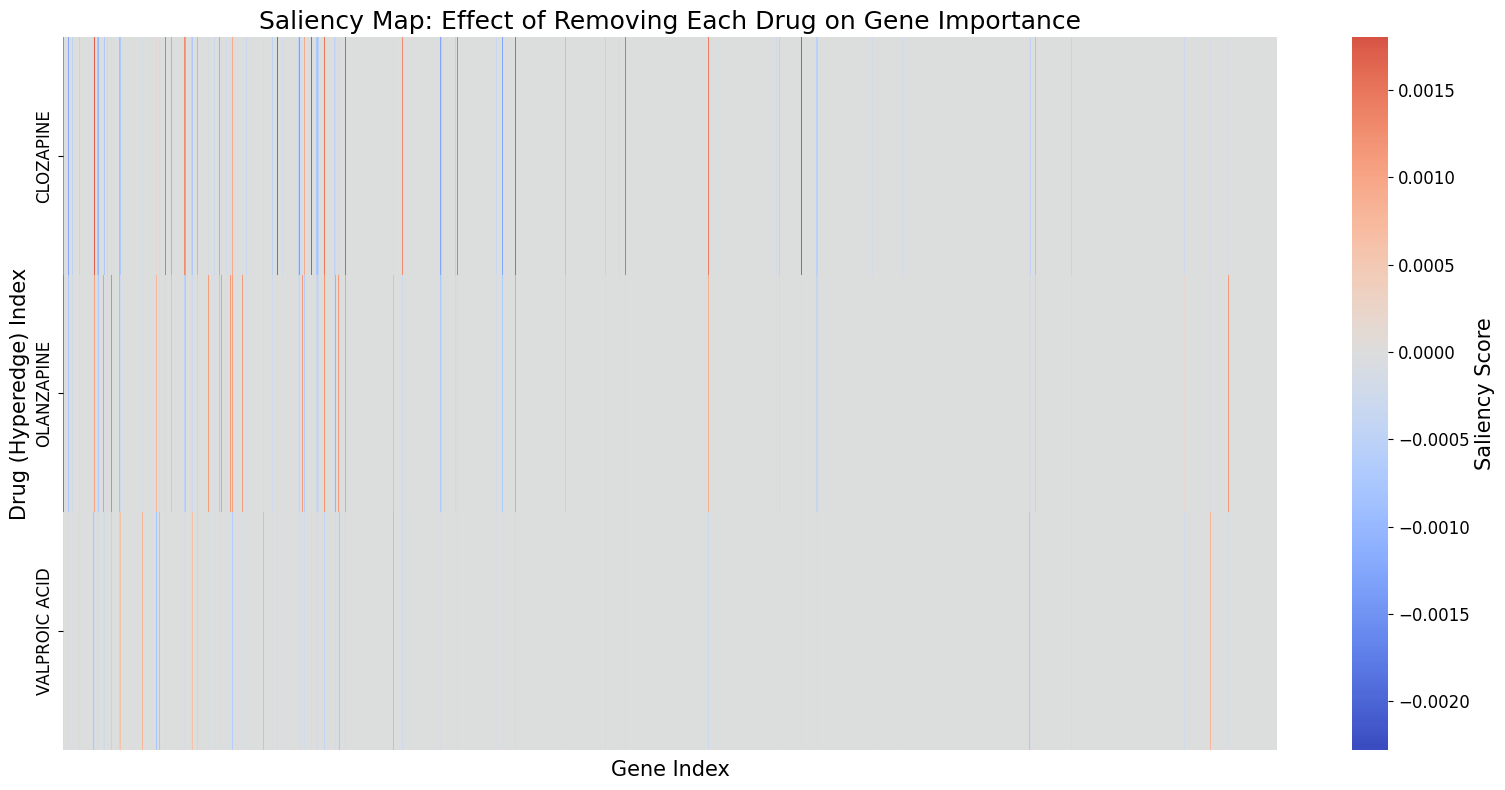

In [31]:
# Define NeurIPS-style font sizes
TITLE_SIZE = 18
LABEL_SIZE = 15
TICK_SIZE = 12

import seaborn as sns
import matplotlib.pyplot as plt
# Filter for specific drugs
drugs_of_interest = ["CLOZAPINE", "OLANZAPINE", "VALPROIC ACID"]
filtered_df = saliency_df.loc[saliency_df.index.isin(drugs_of_interest)]

plt.figure(figsize=(16, 8))

ax = sns.heatmap(
    filtered_df,
    cmap="coolwarm",
    center=0,
    xticklabels=False,
    yticklabels=True,
    cbar_kws={'label': 'Saliency Score'}
)

# Set labels and title
ax.set_xlabel("Gene Index", fontsize=LABEL_SIZE)
ax.set_ylabel("Drug (Hyperedge) Index", fontsize=LABEL_SIZE)
ax.set_title("Saliency Map: Effect of Removing Each Drug on Gene Importance", fontsize=TITLE_SIZE)

# Set tick font sizes
ax.tick_params(axis='x', labelsize=TICK_SIZE)
ax.tick_params(axis='y', labelsize=TICK_SIZE)

# Colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=TICK_SIZE)
cbar.set_label("Saliency Score", fontsize=LABEL_SIZE)

plt.tight_layout()
plt.show()


In [6]:
target_gene_idx = 97  # example gene index
saliency_for_gene = saliency_df[target_gene_idx]

top_contributors = saliency_for_gene.abs().sort_values(ascending=False).head(10)
print(top_contributors)


OLANZAPINE        0.001736
LAMOTRIGINE       0.001630
CLOZAPINE         0.001452
ALLOPURINOL       0.001201
ZIPRASIDONE       0.001185
CLONAZEPAM        0.000940
PERPHENAZINE      0.000852
CARBAMAZEPINE     0.000818
CHLORPROMAZINE    0.000679
LITHIUM           0.000520
Name: 97, dtype: float64


In [10]:
# MAX DIFF:
import pandas as pd
import numpy as np

# Assuming:
# - saliency_df: rows = drug names, columns = gene indices, values = saliency (baseline - perturbed)
# - index_to_drug: dictionary mapping index → drug name (already applied to saliency_df index)

top_perturbations = []

for drug, row in saliency_df.iterrows():
    # Get absolute perturbation values and sort descending
    top5_genes = row.abs().sort_values(ascending=False).head(50)
    # Also get signed values for direction
    top5_signed = row[top5_genes.index]

    # Build dictionary with drug and the top 5 gene-perturbation pairs
    entry = {"Drug": drug}
    for i, gene_idx in enumerate(top5_genes.index):
        entry[f"Gene_{i+1}"] = gene_idx
        entry[f"Perturbation_{i+1}"] = top5_signed[gene_idx]

    top_perturbations.append(entry)

# Create DataFrame
top_perturbations_df = pd.DataFrame(top_perturbations)

# Show example
print(top_perturbations_df.head())


          Drug  Gene_1  Perturbation_1  Gene_2  Perturbation_2  Gene_3  \
0  RISPERIDONE    1000       -0.001830    4156        0.001303    1456   
1    CLOZAPINE    1000       -0.002186     117       -0.002063    3858   
2      LITHIUM    1872        0.000726    2156        0.000726    4411   
3  ALLOPURINOL    4501        0.001738    3733        0.001738     623   
4   OLANZAPINE     117       -0.002276    1000       -0.002260      97   

   Perturbation_3  Gene_4  Perturbation_4  Gene_5  ...  Gene_46  \
0        0.001303     147        0.001303    1450  ...     2276   
1        0.001802    1595        0.001802    1690  ...     1553   
2        0.000726     840        0.000726     797  ...     1016   
3        0.001738    1681        0.001738    4144  ...     2032   
4       -0.001736    1016       -0.001459     504  ...     1626   

   Perturbation_46  Gene_47  Perturbation_47  Gene_48  Perturbation_48  \
0         0.000951     2336         0.000951     2167         0.000951   
1   

In [33]:
# MAX DIFF:
import pandas as pd
import numpy as np

# Assuming:
# - saliency_df: rows = drug names, columns = gene indices, values = saliency (baseline - perturbed)
# - index_to_drug: dictionary mapping index → drug name (already applied to saliency_df index)

top_perturbations = []

for drug, row in saliency_ratio_df.iterrows():
    # Get absolute perturbation values and sort descending
    top5_genes = row.abs().sort_values(ascending=False)
    # Also get signed values for direction
    top5_signed = row[top5_genes.index]

    # Build dictionary with drug and the top 5 gene-perturbation pairs
    entry = {"Drug": drug}
    for i, gene_idx in enumerate(top5_genes.index):
        entry[f"Gene_{i+1}"] = gene_idx
        entry[f"Perturbation_{i+1}"] = top5_signed[gene_idx]

    top_perturbations.append(entry)

# Create DataFrame
top_perturbations_df = pd.DataFrame(top_perturbations)

# Show example
print(top_perturbations_df.head())


          Drug  Gene_1  Perturbation_1  Gene_2  Perturbation_2  Gene_3  \
0  RISPERIDONE    4156        0.968859    1158        0.968859     147   
1    CLOZAPINE     267        0.977276    1530        0.977276    2247   
2      LITHIUM    1872        0.945456    1963        0.945456    1938   
3  ALLOPURINOL     555        0.976469    3739        0.976469    3729   
4   OLANZAPINE    2338        0.963358     667        0.963358     657   

   Perturbation_3  Gene_4  Perturbation_4  Gene_5  ...  Gene_4770  \
0        0.968859       2        0.968859    2152  ...       4729   
1        0.977276    3721        0.977276     819  ...       4729   
2        0.945456    1968        0.945456    2876  ...       4729   
3        0.976469    1681        0.976469    3728  ...       4729   
4        0.963358    1426        0.963358    2692  ...       4729   

   Perturbation_4770  Gene_4771  Perturbation_4771  Gene_4772  \
0                0.0       4730                0.0       4731   
1         

In [8]:
import pandas as pd

if 'NCBI_INFO' not in globals():
    print("Reading gene2refseq.gz...")
    NCBI_INFO = pd.read_csv("../Data/ncbi/gene2refseq.gz", sep='\t', compression='gzip')
else:
    print("NCBI_INFO already loaded.")

Reading gene2refseq.gz...


c:\Users\richa\Desktop\CodingWorkspaces\DGI-Hypergraph-Fin\dgivenv\lib\site-packages\IPython\core\interactiveshell.py:3258: DtypeWarning: Columns (2,4,6,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
index_to_ncbi = {idx: gene for gene, idx in gene_to_index.items()}
human_gene2refseq = NCBI_INFO[NCBI_INFO['#tax_id'] == 9606]
id_to_gene_claim = pd.Series(human_gene2refseq.Symbol.values, index=human_gene2refseq.GeneID).to_dict()

# Your existing function to get common gene name from ncbi gene id
def get_gene_claim_name(ncbi_gene_id):
    try:
        ncbi_gene_id = int(ncbi_gene_id)
        result = id_to_gene_claim.get(ncbi_gene_id, None)
        return result if result else "Gene name not found"
    except:
        return "Gene name not found"

def map_gene_idx_to_common_name(df, index_to_ncbi):
    df_copy = df.copy()
    gene_cols = [col for col in df.columns if col.startswith("Gene_")]
    
    for gene_col in gene_cols:
        # Map gene_idx -> ncbi id -> common name
        df_copy[gene_col] = df_copy[gene_col].map(index_to_ncbi).map(get_gene_claim_name)
    # for i in range(1, 200):
    #     gene_col = f"Gene_{i}"
        
    #     # Map gene_idx -> ncbi id -> common name
    #     df_copy[gene_col] = df_copy[gene_col].map(index_to_ncbi).map(get_gene_claim_name)
    return df_copy

# Apply mapping
top_perturbations_named_df = map_gene_idx_to_common_name(top_perturbations_df, index_to_ncbi)

print(top_perturbations_named_df.head())

          Drug  Gene_1  Perturbation_1   Gene_2  Perturbation_2  Gene_3  \
0  RISPERIDONE  UGT1A9       -0.001830    TENM4        0.001303   POLD3   
1    CLOZAPINE  UGT1A9       -0.002186    GABRE       -0.002063   TANC2   
2      LITHIUM   GATA4        0.000726     UCP2        0.000726     EHF   
3  ALLOPURINOL    LVRN        0.001738  MIR6076        0.001738     MME   
4   OLANZAPINE   GABRE       -0.002276   UGT1A9       -0.002260  CYP1A2   

   Perturbation_3  Gene_4  Perturbation_4    Gene_5  ...  Gene_46  \
0        0.001303   HTR1D        0.001303      RPL5  ...     DLX4   
1        0.001802  ANXA11        0.001802      GGT1  ...   NKX2-5   
2        0.000726     GRP        0.000726     ABCC3  ...   UGT1A5   
3        0.001738    CHUK        0.001738    MBOAT1  ...  NAPEPLD   
4       -0.001736  UGT1A5       -0.001459  MPHOSPH8  ...      FN1   

  Perturbation_46   Gene_47 Perturbation_47  Gene_48 Perturbation_48  Gene_49  \
0        0.000951    ATP1A1        0.000951      DBH 

In [12]:
# Select only columns that start with 'Gene_'
gene_columns = [col for col in top_perturbations_named_df.columns if col.startswith("Gene_")]

# Check which of those columns in the CLOZAPINE row have the value 'GABRE'
clozapine_row = top_perturbations_named_df.loc[1]  # or use .iloc[1] if not using the index directly
matching_columns = [col for col in gene_columns if clozapine_row[col] == "GABRE"]

print(matching_columns)


['Gene_2']


In [13]:
# List of (drug, gene) pairs you're interested in
pairs = [
    ("OLANZAPINE", "GABRE"),
    ("OLANZAPINE", "UGT1A9"),
    ("CLOZAPINE", "UGT1A9"),
    ("CLOZAPINE", "GABRE"),
    ("RISPERIDONE", "UGT1A9"),
    ("OLANZAPINE", "CYP1A2"),
    ("OLANZAPINE", "UGT1A5"),
    ("OLANZAPINE", "MPHOSPH8"),
    ("VALPROIC ACID", "HTR1A"),
    ("VALPROIC ACID", "CACNA1I"),
]

# Find perturbation values for each pair
results = []

for drug, gene in pairs:
    row = top_perturbations_named_df[top_perturbations_named_df["Drug"] == drug]
    for col in row.columns:
        if col.startswith("Gene_"):
            pert_col = col.replace("Gene", "Perturbation")
            match = row[col].values[0] == gene
            if match:
                pert_value = row[pert_col].values[0]
                results.append((drug, gene, pert_value))
                break  # Stop searching once the match is found

# Print results
for drug, gene, value in results:
    print(f"{drug} & {gene} & ${value}$ \\\\")


OLANZAPINE & GABRE & $-0.0022755544047163307$ \\
OLANZAPINE & UGT1A9 & $-0.0022597267594416104$ \\
CLOZAPINE & UGT1A9 & $-0.002185982591424721$ \\
CLOZAPINE & GABRE & $-0.0020633543909175153$ \\
RISPERIDONE & UGT1A9 & $-0.0018302851156458966$ \\
OLANZAPINE & CYP1A2 & $-0.0017356871199307195$ \\
OLANZAPINE & UGT1A5 & $-0.001459196586392238$ \\
OLANZAPINE & MPHOSPH8 & $-0.0013064034914388317$ \\
VALPROIC ACID & HTR1A & $-0.0008422468483556909$ \\
VALPROIC ACID & CACNA1I & $-0.0007977863717297425$ \\


In [35]:
top_perturbations_named_df.to_csv("top_perturbations_named.csv", index=False)

In [ ]:
top_perturbations_named_df = pd.read_csv("./saliency_output/DGIDB_BIPOLAR/top_perturbations_named.csv")

In [35]:


# Collect all (drug, gene, perturbation) tuples
saliency_entries = []

for _, row in top_perturbations_named_df.iterrows():
    drug = row['Drug']
    for i in range(1, 11):
        gene = row[f'Gene_{i}']
        perturb = float(row[f'Perturbation_{i}'])
        saliency_entries.append((drug, gene, perturb))

# Sort for top 5 positive and top 5 negative
top_positive = sorted(saliency_entries, key=lambda x: x[2], reverse=True)[:30]
top_negative = sorted(saliency_entries, key=lambda x: x[2])[:30]

# Display results
print("Top 5 Positive Perturbations:")
for i, (drug, gene, perturb) in enumerate(top_positive, 1):
    print(f"{i}. {drug} — {gene} — {perturb:.8f}")

print("\nTop 5 Negative Perturbations:")
for i, (drug, gene, perturb) in enumerate(top_negative, 1):
    print(f"{i}. {drug} — {gene} — {perturb:.8f}")

Top 5 Positive Perturbations:
1. CLONAZEPAM — PLAGL1 — 0.00304325
2. CLONAZEPAM — CKM — 0.00304325
3. CLONAZEPAM — ARRB2 — 0.00304325
4. CLONAZEPAM — PDE5A — 0.00304325
5. CLONAZEPAM — IDH1 — 0.00304325
6. CLONAZEPAM — CCKBR — 0.00304325
7. CLONAZEPAM — ATP6V0B — 0.00304325
8. CLONAZEPAM — GDNF — 0.00304325
9. CLONAZEPAM — HLA-DRB3 — 0.00304325
10. CLONAZEPAM — DLX5 — 0.00304325
11. CHLORPROMAZINE — RAD50 — 0.00250127
12. CHLORPROMAZINE — FGF2 — 0.00250127
13. CHLORPROMAZINE — CHEK1 — 0.00240786
14. CHLORPROMAZINE — CACNA1I — 0.00240786
15. CHLORPROMAZINE — AMY2A — 0.00240786
16. CHLORPROMAZINE — ELF4 — 0.00240786
17. CHLORPROMAZINE — HTR1A — 0.00235448
18. CHLORPROMAZINE — IL1A — 0.00234091
19. CHLORPROMAZINE — CYP2A6 — 0.00226771
20. LAMOTRIGINE — CGB5 — 0.00220000
21. LAMOTRIGINE — RABEP1 — 0.00220000
22. LAMOTRIGINE — RNF130 — 0.00220000
23. LAMOTRIGINE — NBEAP1 — 0.00220000
24. LAMOTRIGINE — FXN — 0.00220000
25. LAMOTRIGINE — MDGA2 — 0.00220000
26. LAMOTRIGINE — OR10AE3P — 0.00220

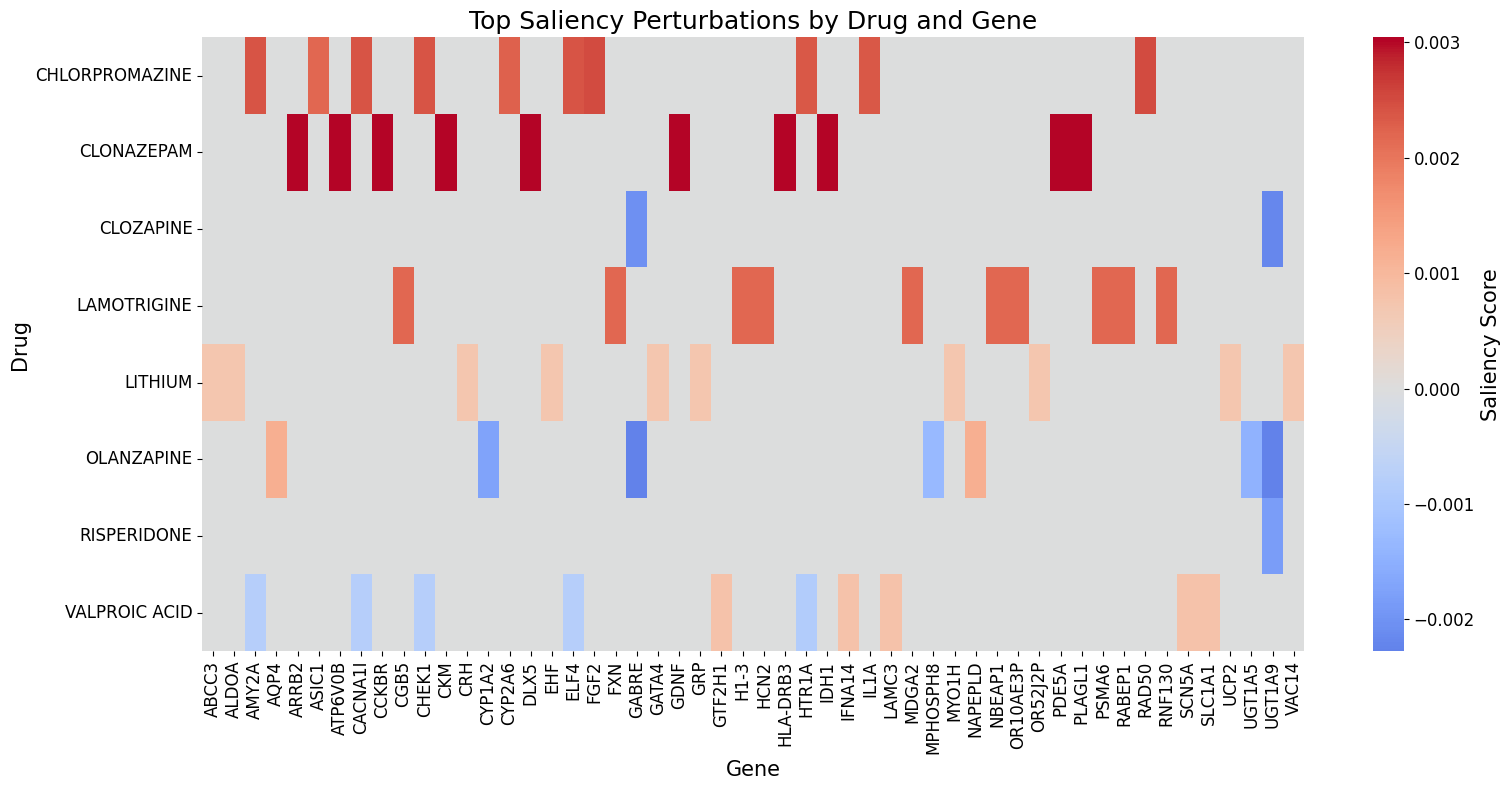

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# NeurIPS-style font sizes
TITLE_SIZE = 18
LABEL_SIZE = 15
TICK_SIZE = 12

# Combine top positive and negative entries
top_entries = top_positive + top_negative

# Create DataFrame from the entries
heatmap_df = pd.DataFrame(top_entries, columns=['Drug', 'Gene', 'Perturbation'])

# Pivot to get matrix form: rows=Drug, columns=Gene
saliency_matrix = heatmap_df.pivot(index='Drug', columns='Gene', values='Perturbation')

# Optional: fill NaNs with 0 or some other placeholder if needed
saliency_matrix = saliency_matrix.fillna(0)

# Plot heatmap
plt.figure(figsize=(16, 8))

ax = sns.heatmap(
    saliency_matrix,
    cmap="coolwarm",
    center=0,
    xticklabels=True,
    yticklabels=True,
    cbar_kws={'label': 'Saliency Score'}
)

ax.set_xlabel("Gene", fontsize=LABEL_SIZE)
ax.set_ylabel("Drug", fontsize=LABEL_SIZE)
ax.set_title("Top Saliency Perturbations by Drug and Gene", fontsize=TITLE_SIZE)

ax.tick_params(axis='x', labelsize=TICK_SIZE, rotation=90)
ax.tick_params(axis='y', labelsize=TICK_SIZE)

# Set colorbar font sizes
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=TICK_SIZE)
cbar.set_label("Saliency Score", fontsize=LABEL_SIZE)

plt.tight_layout()
plt.show()
